In [7]:
from PIL import Image
import numpy as np

In [8]:
img = Image.open("../../artifacts/img.jpg")
img_size = img.size
# halve the size of the image proportionally
img = img.resize((int(img_size[0] / 4), int(img_size[1] / 4)))
img.size

(320, 480)

In [9]:
"""
--nmb_crops 2 6 \
--size_crops 224 96 \
--min_scale_crops 0.14 0.05 \
--max_scale_crops 1. 0.14 \
"""

'\n--nmb_crops 2 6 --size_crops 224 96 --min_scale_crops 0.14 0.05 --max_scale_crops 1. 0.14 '

In [10]:
import parameterized_transforms.transforms as ptx
import parameterized_transforms.wrappers as ptw
from src.data.components.transforms.dino import ParametrizedPILGaussianBlur, ParametrizedSolarization

class ParametrizedDataAugmentationDINO(object):
    def __init__(self, global_crops_scale, local_crops_scale, local_crops_number):
        normalize = ptx.Compose(
            [
                ptx.ToTensor(),
            ]
        )
        self.global_transfo1 = ptw.CastParamsToTensor(
            transform=ptx.Compose(
                [
                    ptx.RandomResizedCrop(
                        224, scale=global_crops_scale, interpolation=Image.BICUBIC
                    ),
                    normalize,
                ]
            )
        )
        # second global crop
        self.global_transfo2 = ptw.CastParamsToTensor(
            transform=ptx.Compose(
                [
                    ptx.RandomResizedCrop(
                        224, scale=global_crops_scale, interpolation=Image.BICUBIC
                    ),
                    normalize,
                ]
            )
        )
        # transformation for the local small crops
        self.local_crops_number = local_crops_number
        self.local_transfo = ptw.CastParamsToTensor(
            transform=ptx.Compose(
                [
                    ptx.RandomResizedCrop(
                        96, scale=local_crops_scale, interpolation=Image.BICUBIC
                    ),
                    normalize,
                ]
            )
        )

    def __call__(self, image):
        crops = []
        crops.append(self.global_transfo1(image))
        crops.append(self.global_transfo2(image))
        for _ in range(self.local_crops_number):
            crops.append(self.local_transfo(image))
        return crops


In [ ]:
from torch import Tensor
import torch
from jaxtyping import Int, Float

def local_to_global(coords: Int[Tensor, "B 2"], params: Tensor, crop_size: int) -> Float[Tensor, "B 2"]:
    """
    Convert coordinates from the transformed image to the original image.
    
    Args:
        coords: Coordinates in the transformed image, shape (B, 2) as (y, x).
        params: A tensor containing at least 5 parameters [y, x, h, w, flip, ...].
        crop_size: The size of the crop (e.g., 160)
    
    Returns:
        A tensor of shape (B, 2) containing the coordinates in the original image.
    """
    # Ensure float type and correct device.

    params, coords = params.float(), coords.float()

    # Extract the top-left corner and size of the crop.
    crop_origin = params[:2]      # [y, x] of the crop in the original image.
    crop_hw = params[2:4]         # [h, w] of the crop.
    crop_scale = crop_hw / crop_size

    return coords * crop_scale + crop_origin

In [ ]:
def global_to_local(global_coords: Float[Tensor, "B 2"], params: Tensor, crop_size: int) -> Float[Tensor, "B 2"]:
    """
    Convert coordinates from the original (global) image to the transformed (local) image.
    
    This is the inverse of the local_to_global transformation.
    
    Args:
        global_coords: Coordinates in the original image, shape (B, 2) as (y, x).
        params: A tensor containing at least 5 parameters [y, x, h, w, flip, ...] used in the crop.
        crop_size: The fixed size of the transformed crop (e.g., 160).
    
    Returns:
        A tensor of shape (B, 2) containing the coordinates in the transformed (local) image.
    """
    # Ensure float type and correct device.
    params, global_coords = params.float(), global_coords.float()

    # Extract the top-left corner and size of the crop.
    crop_origin = params[:2]      # [y, x] of the crop in the original image.
    crop_hw = params[2:4]         # [h, w] of the crop.
    crop_scale = crop_hw / crop_size 

    return (global_coords - crop_origin) / crop_scale

In [13]:
img = Image.open("../../artifacts/samoyed.jpg")
img_size = img.size
# halve the size of the image proportionally
# img = img.resize((int(img_size[0]), int(img_size[1] / 2)))
# img.size
img = img.crop((0, 0, 1000, 1000))

In [ ]:
aug = ParametrizedDataAugmentationDINO(
    global_crops_scale=(0.14, 1.0),
    local_crops_scale=(0.05, 0.30),
    local_crops_number=5,
)

multi_crops = aug(img)

In [26]:
torch.stack([p for _, p in multi_crops]).tolist()

[[154.0, 7.0, 766.0, 699.0],
 [269.0, 381.0, 419.0, 384.0],
 [64.0, 335.0, 310.0, 329.0],
 [489.0, 370.0, 401.0, 518.0],
 [247.0, 219.0, 572.0, 455.0],
 [180.0, 115.0, 574.0, 522.0]]

224
224
96
96
96
96


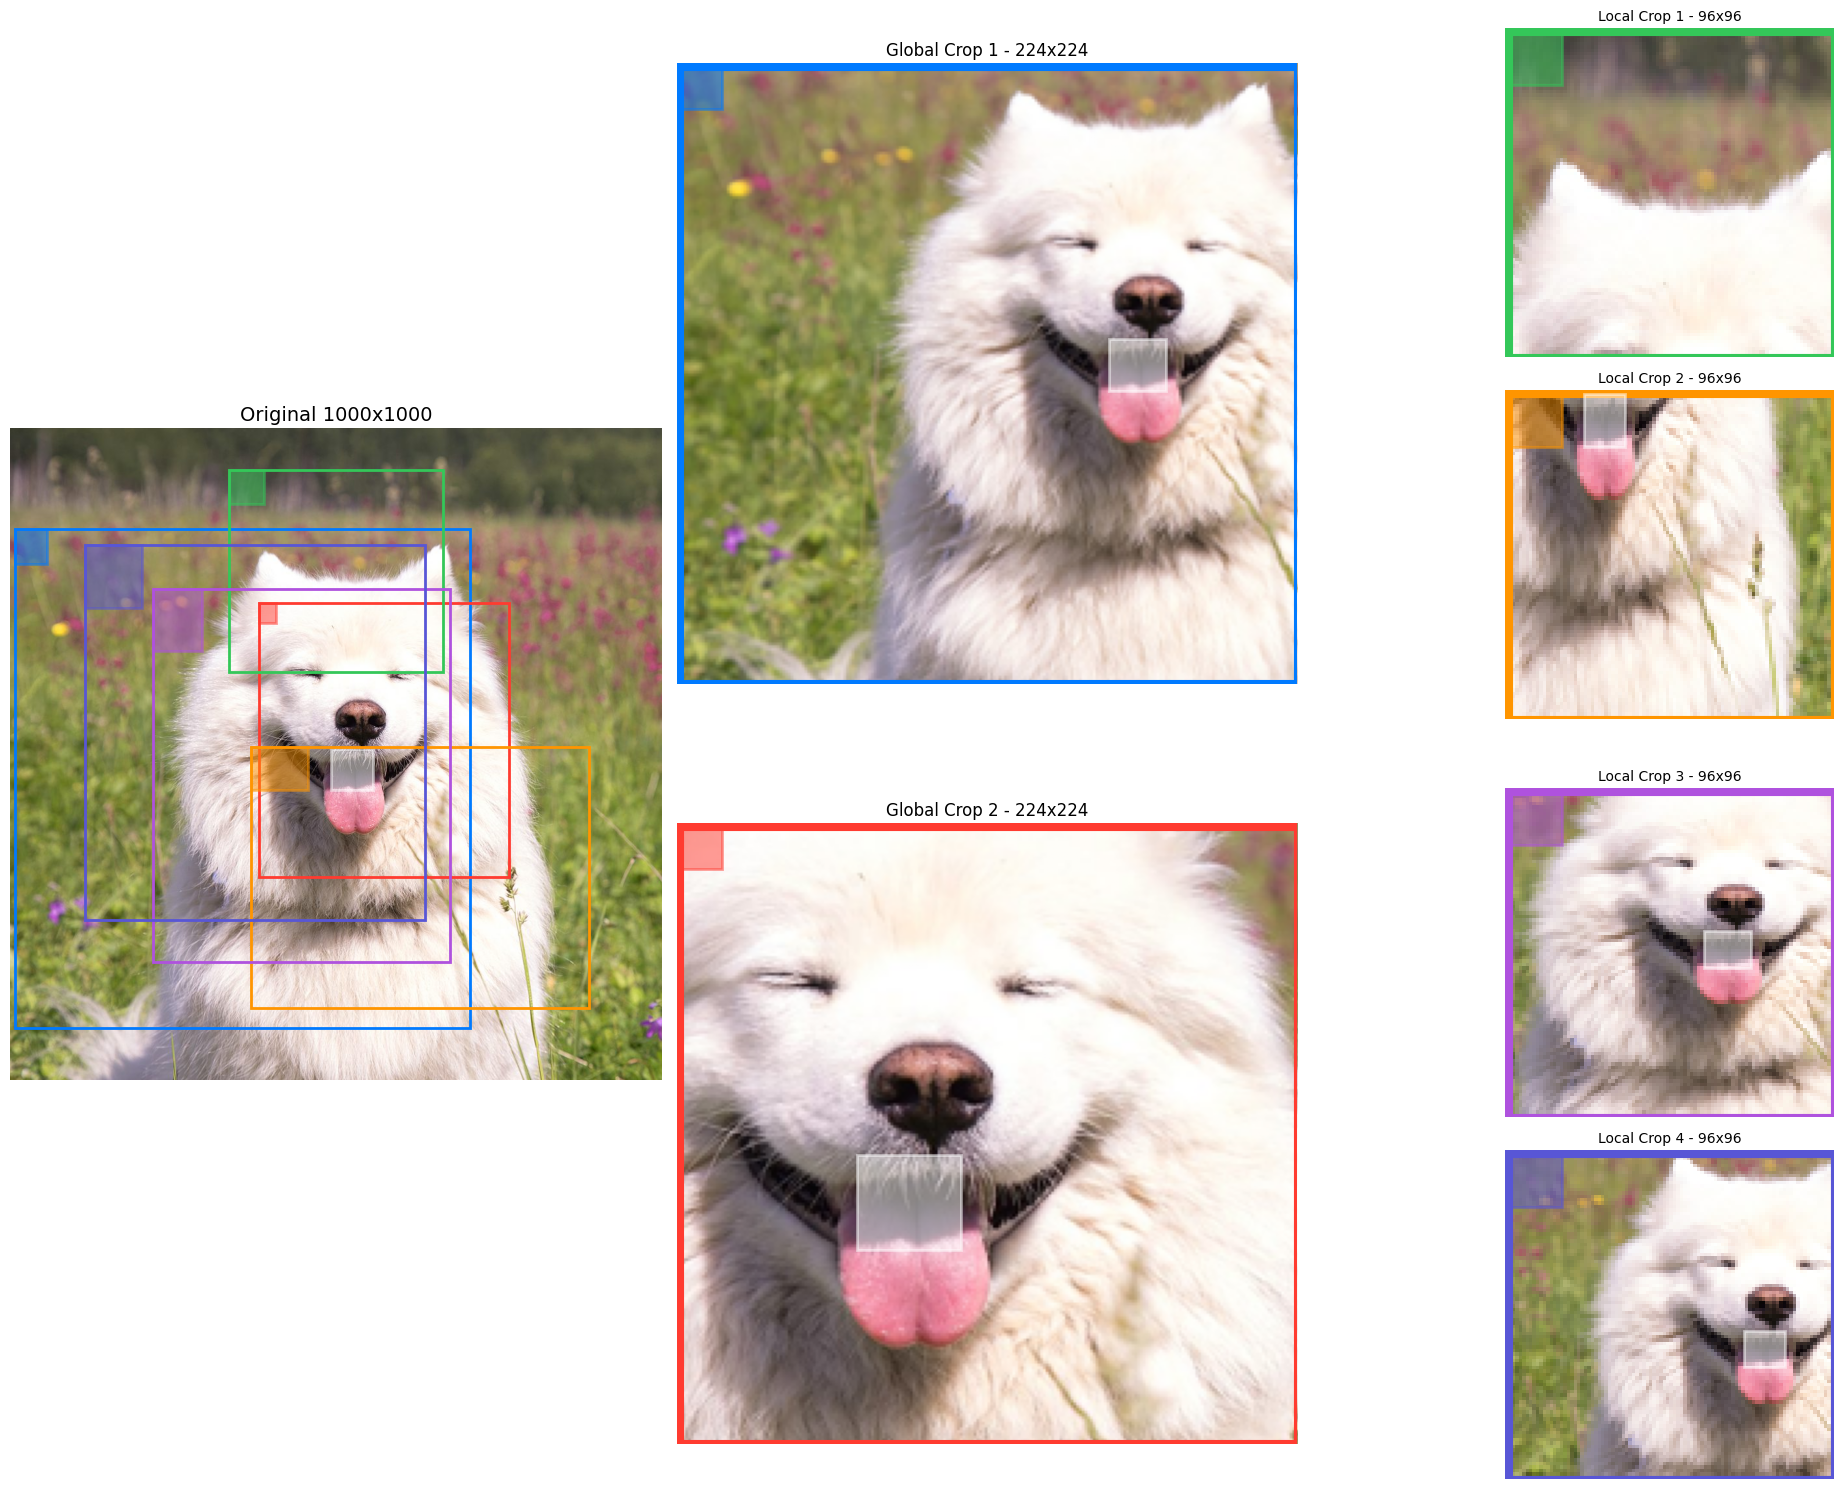

In [15]:
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt

# global_patch = torch.tensor([[492, 492], [492, 508], [508, 492], [508, 508]], dtype=torch.float32)
global_patch_corner = torch.tensor([492, 492], dtype=torch.float32)
global_patch_size = 64
# global_patch consists of the four corners of the patch created from global_patch_corner and global_patch_size
global_patch = torch.tensor(
    [
        [global_patch_corner[0], global_patch_corner[1]],
        [global_patch_corner[0], global_patch_corner[1] + global_patch_size],
        [global_patch_corner[0] + global_patch_size, global_patch_corner[1]],
        [global_patch_corner[0] + global_patch_size, global_patch_corner[1] + global_patch_size],
    ],
    dtype=torch.float32,
)


def plot_crop(fig, ax, crop_tensor, title, color, params, add_border=True):
    """Plot a single crop with optional border"""
    crop_np = np.transpose(crop_tensor.numpy(), (1, 2, 0))
    ax.imshow(crop_np)
    ax.axis("off")
    
    H_crop, W_crop = crop_tensor.size()[-2:]
    ax.set_title(title, fontsize=10 if "Local" in title else 12)
    
    if add_border:
        rect = plt.Rectangle(
            (0, 0), W_crop, H_crop, fill=False, edgecolor=color, linewidth=8
        )
        ax.add_patch(rect)
    
    # plot rectangle (0, 0) to (16, 16) in the crop

    rect = plt.Rectangle(
        (0, 0), 16, 16, fill=True, edgecolor=color, linewidth=2, alpha=0.5, facecolor=color
    )
    ax.add_patch(rect)

    print(crop_tensor.size(-1))
    restored = global_to_local(global_patch, params, crop_size=crop_tensor.size(-1))

    # Draw bounding box
    y_min, x_min = restored.min(dim=0).values
    y_max, x_max = restored.max(dim=0).values
    rect = plt.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        fill=True,
        edgecolor='white',
        facecolor='white',
        linewidth=2,
        alpha=0.5,
    )
    ax.add_patch(rect)


    return ax

def plot_crop_bbox_on_original(ax, crop, params, crop_size, color):
    """Plot bounding box and patch on the original image for a crop"""
    # Define the crop corners
    corners = torch.tensor(
        [
            [0, 0],
            [0, crop.size(-1)],
            [crop.size(-2), 0],
            [crop.size(-2), crop.size(-1)],
        ],
        dtype=torch.float32,
    )
    restored = local_to_global(corners, params, crop_size=crop_size)

    # Draw bounding box
    y_min, x_min = restored.min(dim=0).values
    y_max, x_max = restored.max(dim=0).values
    rect = plt.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        fill=False,
        edgecolor=color,
        linewidth=2,
    )
    ax.add_patch(rect)

    # Draw patch
    patch = torch.tensor([[0, 0], [0, 16], [16, 0], [16, 16]], dtype=torch.float32)
    restored = local_to_global(patch, params, crop_size=crop_size)
    y_min, x_min = restored.min(dim=0).values
    y_max, x_max = restored.max(dim=0).values
    rect = plt.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        edgecolor=color,
        linewidth=2,
        fill=True,
        alpha=0.5,
        facecolor=color,
    )
    ax.add_patch(rect)

# Create figure
fig = plt.figure(figsize=(20, 15))

# Create a grid with 4 rows and 2 columns (left for original, right for crops)
gs = gridspec.GridSpec(4, 2, width_ratios=[1, 2])

# Plot original image in the left column spanning all rows
ax_orig = fig.add_subplot(gs[:, 0])
ax_orig.imshow(np.array(img))
ax_orig.axis("off")
ax_orig.set_title(f"Original {img.size[1]}x{img.size[0]}", fontsize=14)

# plot global_patch
# rect = plt.Rectangle(
#     (492, 492), 16, 16, fill=True, edgecolor="red", linewidth=2, alpha=0.5, facecolor="red"
# )
rect = plt.Rectangle(
    global_patch_corner, global_patch_size, global_patch_size, fill=True, edgecolor="white", linewidth=2, alpha=0.5, facecolor="white"
)   
ax_orig.add_patch(rect)

# Color mapping for different crops
crop_colors = ["#007AFF", "#FF3B30", "#34C759", "#FF9500", "#AF52DE", "#5856D6"]

# Create 2x2 grid for the right column to hold global and local crops
crops_gs = gridspec.GridSpecFromSubplotSpec(
    2, 2, subplot_spec=gs[:, 1], wspace=0.1, hspace=0.1
)

# Plot global crops (top-left and bottom-left of right section)
for i in range(2):
    ax_global = fig.add_subplot(crops_gs[i, 0])
    crop_tensor = multi_crops[i][0]
    H_crop, W_crop = crop_tensor.size()[-2:]
    title = f"Global Crop {i+1} - {H_crop}x{W_crop}"
    params = multi_crops[i][1]
    plot_crop(fig, ax_global, crop_tensor, title, crop_colors[i], params)

# Create nested grids for local crops
local_gs1 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=crops_gs[0, 1], hspace=0.1)
local_gs2 = gridspec.GridSpecFromSubplotSpec(2, 1, subplot_spec=crops_gs[1, 1], hspace=0.1)

# Plot first two local crops (top right)
for i in range(2):
    ax_local = fig.add_subplot(local_gs1[i])
    crop_idx = i + 2  # Offset by 2 because first two are global crops
    crop_tensor = multi_crops[crop_idx][0]
    H_crop, W_crop = crop_tensor.size()[-2:]
    title = f"Local Crop {i+1} - {H_crop}x{W_crop}"
    params = multi_crops[crop_idx][1]
    plot_crop(fig, ax_local, crop_tensor, title, crop_colors[crop_idx], params)

# Plot second two local crops (bottom right)
for i in range(2):
    ax_local = fig.add_subplot(local_gs2[i])
    crop_idx = i + 4  # Offset by 4 (2 global + 2 local)
    crop_tensor = multi_crops[crop_idx][0]
    H_crop, W_crop = crop_tensor.size()[-2:]
    title = f"Local Crop {i+3} - {H_crop}x{W_crop}"
    params = multi_crops[crop_idx][1]
    plot_crop(fig, ax_local, crop_tensor, title, crop_colors[crop_idx], params) 

# Plot bounding boxes on the original image
for i, (crop, params) in enumerate(multi_crops):
    crop_size = 224 if i < 2 else 96  # First two are global crops
    plot_crop_bbox_on_original(ax_orig, crop, params, crop_size, crop_colors[i])

plt.tight_layout()
plt.show()


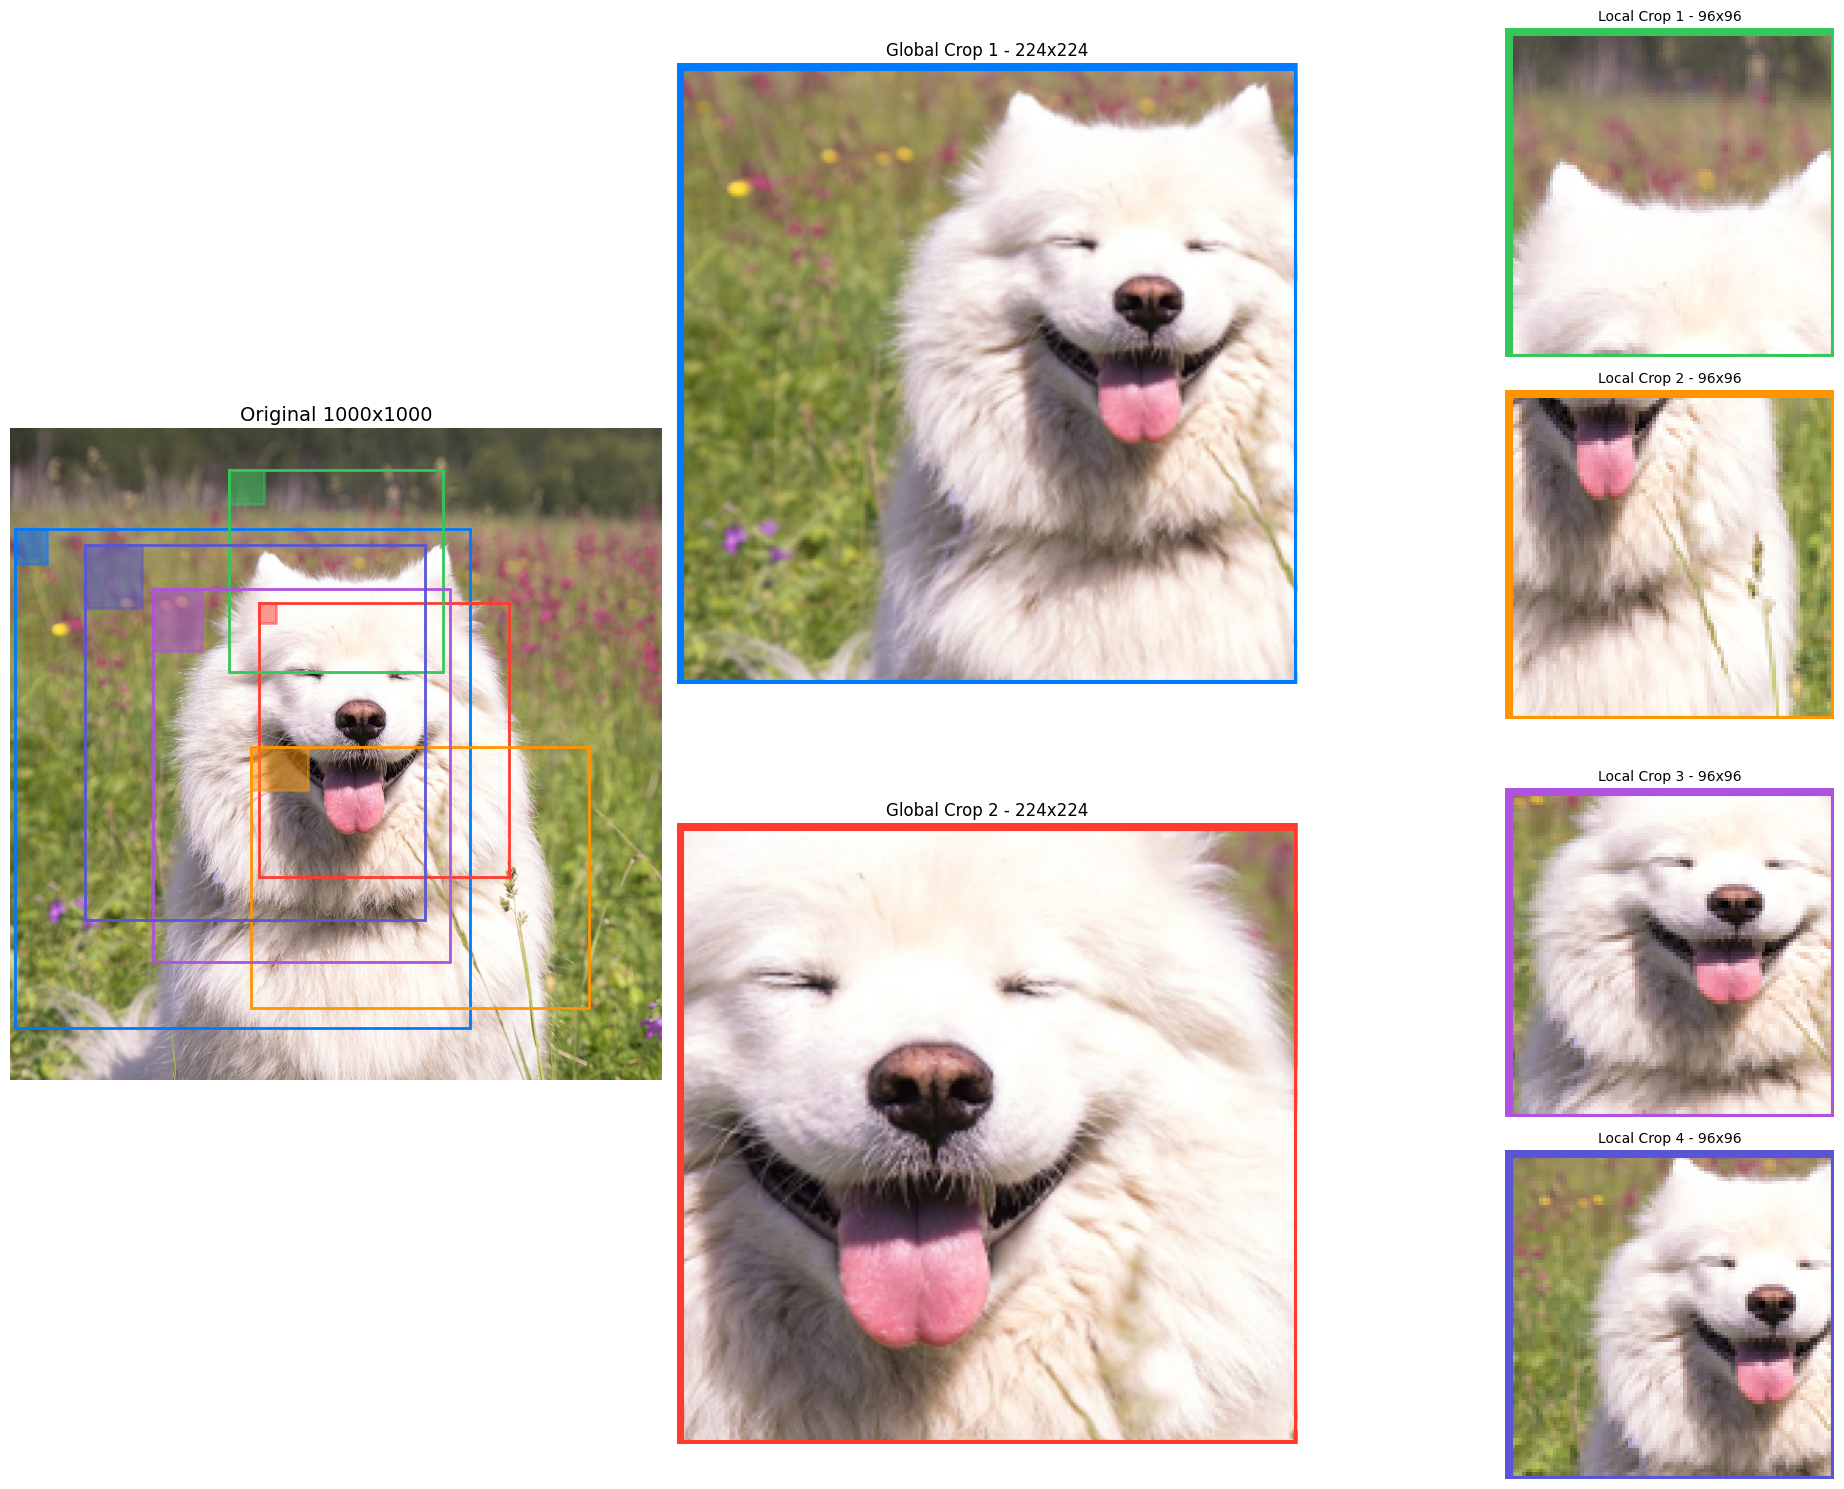

In [16]:
import matplotlib.gridspec as gridspec

# Create figure
fig = plt.figure(figsize=(20, 15))

# Create a grid with 4 rows and 2 columns
# First column for original image, second for global and local crops side by side
gs = gridspec.GridSpec(4, 2, width_ratios=[1, 2])

# Plot original image in the left column spanning all rows
ax_orig = fig.add_subplot(gs[:, 0])
ax_orig.imshow(np.array(img))
ax_orig.axis("off")
ax_orig.set_title(f"Original {img.size[1]}x{img.size[0]}", fontsize=14)

# Color mapping for different crops
crop_colors = ["#007AFF", "#FF3B30", "#34C759", "#FF9500", "#AF52DE", "#5856D6"]

# Create 2x2 grid for the right column to hold global and local crops
crops_gs = gridspec.GridSpecFromSubplotSpec(
    2, 2, subplot_spec=gs[:, 1], wspace=0.1, hspace=0.1
)

# Plot first global crop in top-left of right grid
ax_global1 = fig.add_subplot(crops_gs[0, 0])
crop_np = np.transpose(multi_crops[0][0].numpy(), (1, 2, 0))
ax_global1.imshow(crop_np)
ax_global1.axis("off")
H_crop, W_crop = multi_crops[0][0].size()[-2:]
ax_global1.set_title(f"Global Crop 1 - {H_crop}x{W_crop}", fontsize=12)
# add a color border to crop of color crop_colors[0]
rect = plt.Rectangle(
    (0, 0), W_crop, H_crop, fill=False, edgecolor=crop_colors[0], linewidth=8
)
ax_global1.add_patch(rect)

# Plot second global crop in bottom-left of right grid
ax_global2 = fig.add_subplot(crops_gs[1, 0])
crop_np = np.transpose(multi_crops[1][0].numpy(), (1, 2, 0))
ax_global2.imshow(crop_np)
ax_global2.axis("off")
H_crop, W_crop = multi_crops[1][0].size()[-2:]
ax_global2.set_title(f"Global Crop 2 - {H_crop}x{W_crop}", fontsize=12)

# add a color border to crop of color crop_colors[1]
rect = plt.Rectangle(
    (0, 0), W_crop, H_crop, fill=False, edgecolor=crop_colors[1], linewidth=8
)
ax_global2.add_patch(rect)


# Create nested grid for local crops - top right
local_gs1 = gridspec.GridSpecFromSubplotSpec(
    2, 1, subplot_spec=crops_gs[0, 1], hspace=0.1
)
# Create nested grid for local crops - bottom right
local_gs2 = gridspec.GridSpecFromSubplotSpec(
    2, 1, subplot_spec=crops_gs[1, 1], hspace=0.1
)

# Plot first two local crops next to first global crop
for i in range(2):
    ax_local = fig.add_subplot(local_gs1[i])
    crop_idx = i + 2  # Offset by 2 because first two are global crops
    crop_np = np.transpose(multi_crops[crop_idx][0].numpy(), (1, 2, 0))
    ax_local.imshow(crop_np)
    ax_local.axis("off")
    H_crop, W_crop = multi_crops[crop_idx][0].size()[-2:]
    ax_local.set_title(f"Local Crop {i+1} - {H_crop}x{W_crop}", fontsize=10)
    rect = plt.Rectangle(
        (0, 0), W_crop, H_crop, fill=False, edgecolor=crop_colors[crop_idx], linewidth=8
    )
    ax_local.add_patch(rect)

# Plot second two local crops next to second global crop
for i in range(2):
    ax_local = fig.add_subplot(local_gs2[i])
    crop_idx = i + 4  # Offset by 4 (2 global + 2 local)
    crop_np = np.transpose(multi_crops[crop_idx][0].numpy(), (1, 2, 0))
    ax_local.imshow(crop_np)
    ax_local.axis("off")
    H_crop, W_crop = multi_crops[crop_idx][0].size()[-2:]
    ax_local.set_title(f"Local Crop {i+3} - {H_crop}x{W_crop}", fontsize=10)

    # add a color border to crop of color crop_colors[i]
    rect = plt.Rectangle(
        (0, 0), W_crop, H_crop, fill=False, edgecolor=crop_colors[crop_idx], linewidth=8
    )
    ax_local.add_patch(rect)


# Plot bounding boxes on the original image
for i, (crop, params) in enumerate(multi_crops):
    # Define the crop corners in (y, x) order
    crop_size = 224 if i < 2 else 96  # First two are global crops
    corners = torch.tensor(
        [
            [0, 0],
            [0, crop.size(-1)],
            [crop.size(-2), 0],
            [crop.size(-2), crop.size(-1)],
        ],
        dtype=torch.float32,
    )
    restored = local_to_global(corners, params, crop_size=crop_size)

    # Compute bounding box of restored coordinates
    y_min, x_min = restored.min(dim=0).values
    y_max, x_max = restored.max(dim=0).values
    rect = plt.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        fill=False,
        edgecolor=crop_colors[i],
        linewidth=2,
    )
    ax_orig.add_patch(rect)

    patch = torch.tensor([[0, 0], [0, 16], [16, 0], [16, 16]], dtype=torch.float32)
    restored = local_to_global(patch, params, crop_size=crop_size)
    y_min, x_min = restored.min(dim=0).values
    y_max, x_max = restored.max(dim=0).values

    rect = plt.Rectangle(
        (x_min, y_min),
        x_max - x_min,
        y_max - y_min,
        edgecolor=crop_colors[i],
        linewidth=2,
        # linestyle="--",
        fill=True,
        alpha=0.5   ,
        facecolor=crop_colors[i],
    )
    ax_orig.add_patch(rect)


plt.tight_layout()
plt.show()

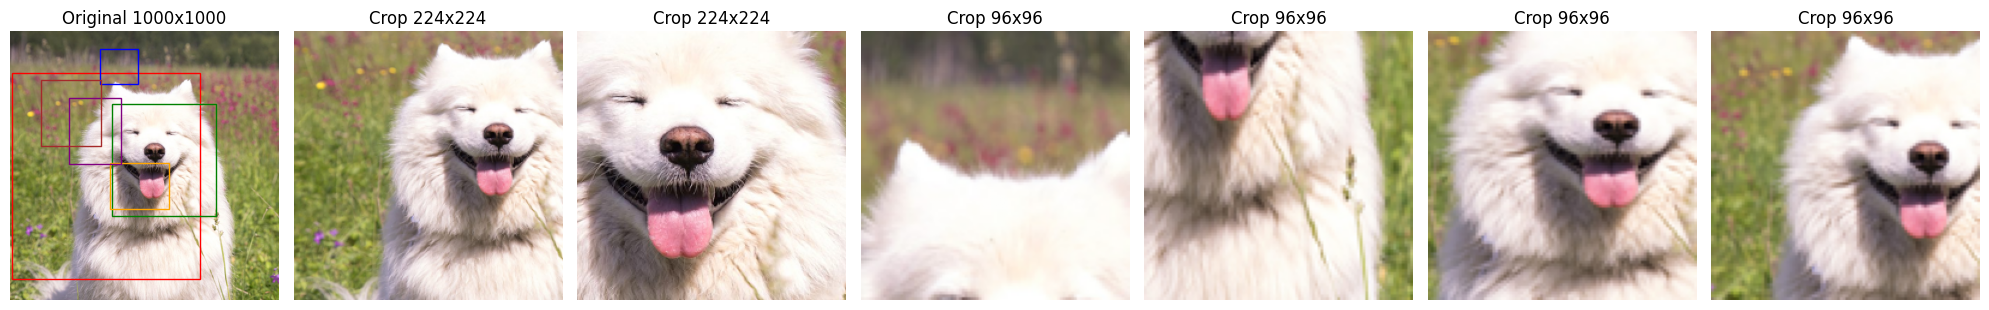

In [17]:
# Create a figure with 1 row and (1 + number of crops) columns
fig, axes = plt.subplots(1, 1 + len(multi_crops), figsize=(20, 10))
ax_orig = axes[0]

# Plot the original image
ax_orig.imshow(np.array(img))
ax_orig.axis("off")
ax_orig.set_title(f"Original {img.size[1]}x{img.size[0]}")  # PIL: size=(W,H), display as HxW
crop_colors = ["red", "green", "blue", "orange", "purple", "brown"]

# For each crop, plot the crop and add its bounding box on the original image
for i, (crop, params) in enumerate(multi_crops):
    # Plot the crop in its own subplot
    ax_crop = axes[i+1]
    crop_np = np.transpose(crop.numpy(), (1, 2, 0))
    ax_crop.imshow(crop_np)
    ax_crop.axis("off")
    H_crop, W_crop = crop.size()[-2:]
    ax_crop.set_title(f"Crop {H_crop}x{W_crop}")

    # Define the crop corners in (y, x) order (top-left, top-right, bottom-left, bottom-right)
    corners = torch.tensor([[0, 0], [0, W_crop], [H_crop, 0], [H_crop, W_crop]], dtype=torch.float32)
    restored = local_to_global(corners, params, crop_size=224)

    # Compute bounding box of restored coordinates
    y_min, x_min = restored.min(dim=0).values
    y_max, x_max = restored.max(dim=0).values
    rect = plt.Rectangle(
        (x_min, y_min), x_max - x_min, y_max - y_min,
        fill=False, edgecolor=crop_colors[i]
    )
    ax_orig.add_patch(rect)

plt.tight_layout()
plt.show()
